In [9]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import scipy as sp
from autograd import grad, jacobian

# Pennylane numpy
from pennylane import numpy as pnp 

In [10]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=1)

# Define Hamiltonian for quantum computations
coeffs = [-0.5]
obs = [qml.PauliZ(0)]
hamiltonian = qml.Hamiltonian(coeffs, obs)

In [11]:
# Global Parameters
Tau_global = 5e-2   # Dephase tau
Paras_global = pnp.zeros(2)
Phi_global = 0
Gamma_ps = 0

# Data Index
class DataIndex(Enum):
    BEFORE = 0
    PHI = 0
    CFI = 1
    PARAS = 2
    THETA_X = 2
    PHI_Z = 3

def Dephase_factor(tau):
    """
    Calculate the dephasing factor (gamma) based on the provided tau value.

    Args:
        tau (float): Dephasing time constant.

    Returns:
        float: Calculated dephasing factor (gamma).
    """
    return 1 - pnp.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau}
$$

$$
\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

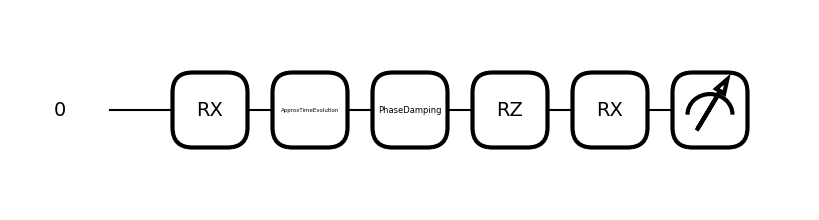

In [12]:
@qml.qnode(dev)
def circuit(paras):
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = paras

    qml.RX(pnp.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)


@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator for 2*2 matrix
    K = pnp.array([
        [pnp.sqrt(1 - Gamma_ps), 0],
        [0, 1]
    ])
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = pnp.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

$$
\rho_{ps} = 

\frac{K \rho K^{\dagger}}

{Tr[K \rho K^{\dagger}]}
$$

$$
where, \quad
K = 
\begin{bmatrix}

\sqrt{1 - \gamma} & 0 \\

0 & 1

\end{bmatrix}
$$

In [13]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, pnp.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [14]:
gradient = grad(Cost_function)
hessian = jacobian(gradient)

In [15]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def run_optimization(sweep_data, initial_parameters, gamma_ps, iterations):
    """ 
    Main function to perform optimization over a range of phi values using the BFGS algorithm.
    
    Args:
        sweep_data (tuple): (start, end, step) values for the phi sweep.
        initial_parameters (numpy_array): Initial parameters for optimization.
        gamma_ps (int): Gamma value for post-selection.
        iterations (int): Number of iterations for the optimization.

    Returns:
        numpy.ndarray: A 3-D array containing phi, CFI, and optimized parameters after each iteration.
    """
    
    # Create Data array
    PHI = np.arange(sweep_data[0], sweep_data[1], sweep_data[2])
    Data = np.zeros((iterations + 1, len(PHI), len(initial_parameters) + 2)) 
    Data[:, :, DataIndex.PHI.value] = PHI.squeeze() # Append PHI in to 0th col
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global, Tau_global
    Gamma_ps = gamma_ps 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Store initial CFI data and parameters
    for idx, phi in enumerate(PHI):
        Data[DataIndex.BEFORE.value][idx][DataIndex.CFI.value] = -Cost_function(initial_parameters)
        Data[DataIndex.BEFORE.value][idx][DataIndex.PARAS.value:] = initial_parameters
        
    # Optimize begin
    for iteration in range(1, iterations + 1):
        for phi_idx, phi_current in enumerate(PHI):
            # Determine initial parameters based on the iteration
            if iteration == 1:
                Paras_Temporary = initial_parameters
                
            else:
                Paras_Temporary = Data[iteration][phi_idx][DataIndex.PARAS.value:]
            
            # Update the global Phi value
            Phi_global = phi_current

            # Determine constraints
            Constraints = get_constraints(phi_current, gamma_ps, Tau_global)

            # Optimize the data
            N = int(phi_current / pnp.pi) * pnp.pi
            if Gamma_ps == 8e-1:
                if Tau_global == 0:
                    Paras_Temporary = pnp.array([pnp.pi/2, pnp.pi/2])

                elif (pnp.pi/2 + N <= phi_current <= 2.1 + N):   # Up next
                    Paras_Temporary = pnp.array([pnp.pi/2, 1])

            Paras_global = Paras_Temporary


            Result_BFGS = BFGS(Paras_Temporary, Constraints)
            print("CFI =", -Result_BFGS.fun, "Paras =", Result_BFGS.x)
            Data[iteration][phi_idx][DataIndex.CFI.value] = -Result_BFGS.fun
            Data[iteration][phi_idx][DataIndex.PARAS.value:] = Result_BFGS.x
            
    return Data

def BFGS(initial_parameters, constraints):
    """
    Perform the BFGS optimization algorithm.

    Args:
        initial_parameters (numpy_array): The starting point for the optimization.
        constraints (list of tuple): Bounds on the variables for the optimization.

    Returns:
        OptimizeResult: The result of the optimization process.
    """
    
    optimization_result = sp.optimize.minimize(
                fun = Cost_function, 
                x0 = initial_parameters, 
                method = 'L-BFGS-B', 
                bounds = constraints,
                jac = gradient,
                hess = hessian,
                tol = 1e-20,
                options={
                    'ftol': 1e-20, 
                    'gtol': 1e-20
                }
            )
    return optimization_result

def get_constraints(phi_current, gamma_ps, tau_current):
    """
    Calculate the constraints for the optimization based on current phi, gamma and tau values.

    Args:
        phi_current (float): The current value of phi in the optimization loop.
        gamma_ps (float): Gamma value for post-selection.
        tau_current (float): Current value of tau.

    Returns:
        list of tuple: Constraints for the optimization variables.
    """
    
    N = 2*np.pi * int(phi_current / (2*np.pi))
    if gamma_ps == 8e-1:
        if tau_current == 0:
            # return [(-float('inf'), float('inf'))] * 2
            return [
                (np.pi/2, np.pi/2),
                (-np.pi/2, 3*np.pi/2)
            ]

        elif tau_current == (5e-2):
            if phi_current < 0.45 + N:
                return [(np.pi/2, np.pi)] * 2
            elif phi_current <= 1.02 + N:
                return [(np.pi/2, 3.70)] * 2
            elif phi_current <= 1.57 + N:
                return [(np.pi/2, 4.24006637)] * 2
            elif 3.00 + N <= phi_current <= 3.67 + N:
                return [(np.pi/2, np.pi/2), (0.32993364, 0.99993333)]
            elif 3.69 + N <= phi_current <= 4.0 + N:
                return [(np.pi/2, np.pi/2), (1.01993369, 1.32993365)]
            elif 4.03 + N <= phi_current <= 4.22 + N:
                return [(np.pi/2, np.pi/2), (1.35993364, 1.54993374)]
            elif 4.24 + N <= phi_current <= 4.69 + N:
                return [(np.pi/2, np.pi/2), (1.56993364, 2.01993363)]
            elif (4.82) + N <= phi_current <= (5.5) + N:
                return [(np.pi/2, np.pi/2), (1.20688106, 1.88688109)]
            elif 5.5 + N <= phi_current <= (6.0) + N:
                return [(np.pi/2, np.pi/2), (1.88688109, 2.38688106)]
            elif 6.05 + N <= phi_current <= (6.15) + N:
                return [(np.pi/2, np.pi/2), (2.43688084, 2.53688103)]

        elif tau_current == 2e-1:
            if phi_current <= 0.5 + N:
                return [(0, np.pi)] * 2
            elif phi_current < 1.58 + N:
                return [(-0.8439553621272445, 3.9939553536152146)] * 2 
            elif phi_current < 2.42 + N:
                return [(-0.8439553621272445, 3.9939553536152146)] * 2 
            elif phi_current < 4 + N:
                return [(0, np.pi/2)] * 2 
            elif phi_current < (1.57 + 3.14) + N:
                return [(np.pi/2, np.pi)] * 2 
        
        elif tau_current == 5e-1:
            return [(-5e-1, pnp.pi + 6e-1 )] * 2
        
        elif 1 <= tau_current <= 4:
            return [(-5e-1, pnp.pi + 35e-2)] * 2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


CFI = 4.99999861341226 Paras = [1.57079633 3.1413193 ]
CFI = 4.999998630241996 Paras = [1.57079633 3.1513255 ]
CFI = 4.999998592448064 Paras = [1.57079633 3.16133945]
CFI = 4.9999986087949875 Paras = [1.57079633 3.17131112]
CFI = 4.999998626138756 Paras = [1.57079633 3.18132696]
CFI = 4.99999862838912 Paras = [1.57079633 3.19133041]
CFI = 4.999998620452715 Paras = [1.57079633 3.201326  ]
CFI = 4.999998625525178 Paras = [1.57079633 3.21185712]
CFI = 4.9999986119762285 Paras = [1.57079633 3.22187414]
CFI = 4.99999861364082 Paras = [1.57079633 3.2313141 ]
CFI = 4.999998632346641 Paras = [1.57079633 3.24132414]
CFI = 4.999998634762808 Paras = [1.57079633 3.2513267 ]
CFI = 4.999998636253886 Paras = [1.57079633 3.26185487]
CFI = 4.999998621148096 Paras = [1.57079633 3.27185759]
CFI = 4.999998614749201 Paras = [1.57079633 3.28185798]
CFI = 4.9999986140471036 Paras = [1.57079633 3.29132873]
CFI = 4.999998631143267 Paras = [1.57079633 3.30185828]
CFI = 4.99999859740869 Paras = [1.57079633 3.311

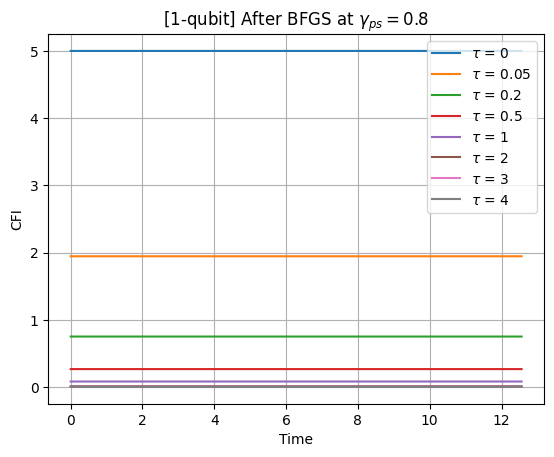

In [16]:
tau_plot = 0, 5e-2, 2e-1, 5e-1, 1, 2, 3, 4

Sweep_data = np.array([0, pnp.pi*4,  1e-2])  #1e-2 ~ (4pi + 1e-2)
Sweep_data_arange = np.arange(Sweep_data[0], Sweep_data[1], Sweep_data[2])

Para_store = pnp.zeros((len(tau_plot), len(Sweep_data_arange), 2))

for idx,tau_current in enumerate(tau_plot):
    Tau_global = tau_current
    
    Paras_init = pnp.zeros(2)
    if tau_current == 0 or 5e-2 or 2e-1:
        Paras_init[:2] = (1*pnp.pi)/2

    else:
        Paras_init[:2] = (1.1*pnp.pi)/2    # 1.1pi/2 for all tau's (without tau = 0)

    Gamma_ps_preset = 8e-1
    Set_Iterations = 1

    Optimized_Result = run_optimization(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)

    Para_store[idx][:, 0] = Optimized_Result[Set_Iterations][:,DataIndex.THETA_X.value]
    Para_store[idx][:, 1] = Optimized_Result[Set_Iterations][:,DataIndex.PHI_Z.value]

    plt.plot(Sweep_data_arange, Optimized_Result[1][:, DataIndex.CFI.value], label = f'$\\tau$ = {tau_current}')

plt.title(f'[1-qubit] After BFGS at $\gamma_{{ps}} = {Gamma_ps_preset}$')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

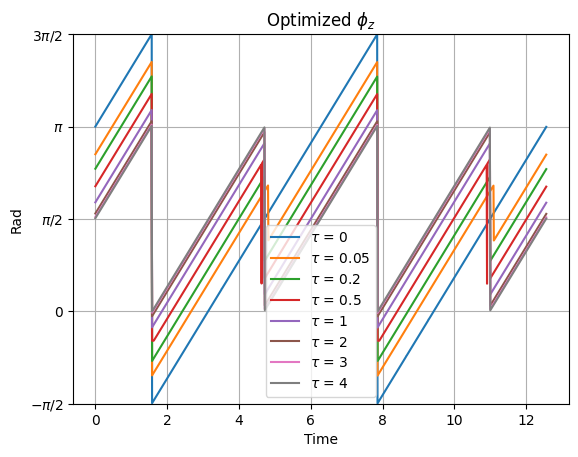

In [17]:
for idx, tau in enumerate(tau_plot):
    # if idx, tau != 4:
        plt.plot(Sweep_data_arange, Para_store[idx][:, 1], label = f'$\\tau$ = {tau}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
# plt.yticks([-pnp.pi, 0, pnp.pi, 2*pnp.pi], ['$-\pi$', '0', '$\pi$', '$2\pi$'])
plt.yticks([-pnp.pi, -pnp.pi/2, 0, pnp.pi/2, pnp.pi, (3*pnp.pi)/2, 2*pnp.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(-pnp.pi/2, 3*pnp.pi/2)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

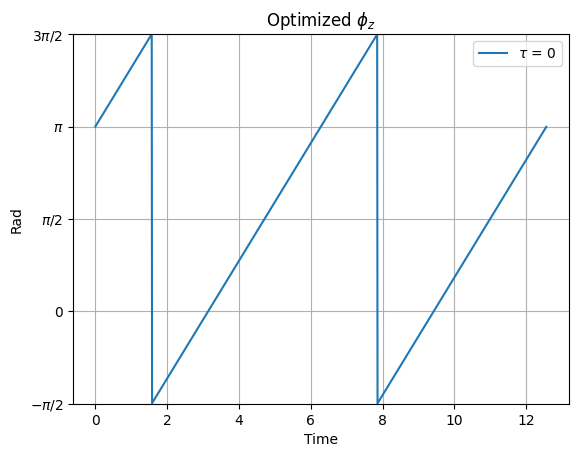

In [18]:
slice = int(len(Sweep_data_arange) / 1)

tau_order = 0,

for idx, tau in enumerate(tau_order):
    plt.plot(Sweep_data_arange[:slice], Para_store[tau][:slice, 1], label = f'$\\tau$ = {tau_plot[tau]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-pnp.pi, -pnp.pi/2, 0, pnp.pi/2, pnp.pi, (3*pnp.pi)/2, 2*pnp.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(-1*pnp.pi/2, 3*pnp.pi/2)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

In [19]:
# indices = np.where(Para_store[1][:, 1] <= 2e-1)
indices = np.where(Para_store[0][:, 1] > 2*pnp.pi)

indices

(array([], dtype=int64),)

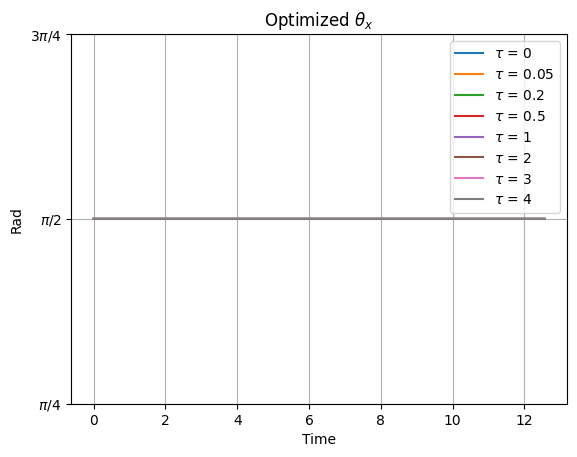

In [20]:
for idx, tau in enumerate(tau_plot):
    plt.plot(Sweep_data_arange, Para_store[idx][:, 0], label = f'$\\tau$ = {tau}')

# Set the yticks to be at π/4, π/2, and 3π/4
plt.yticks([pnp.pi/4, pnp.pi/2, 3*pnp.pi/4], ['$\pi/4$', '$\pi/2$', '$3\pi/4$'])

plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()